In [80]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from timeit import default_timer as timer
import math
from tabulate import tabulate

In [81]:
A = np.random.randn(1000,10)
np.random.seed(1000)
x_bar = []
for i in range(1,11):
  if i%2 ==0:
    x_bar.append(rnd.uniform(i,i+1))
  else:
    x_bar.append(rnd.uniform(-i-1,-i))
x_bar = np.array(x_bar).reshape(10,1)   
epsilon = np.random.randn(1000,1)  
y = np.matmul(A,x_bar) + epsilon

## **Answer 1:**

In [82]:
def evalf(x,n):
  assert type(x) is np.ndarray and len(x) == n
  f_val = 0.5*(np.linalg.norm(np.matmul(A,x) - y))**2
  return f_val  

In [83]:
def evalg(x, n):
  assert type(x) is np.ndarray and len(x) == n
  grad = np.matmul(A.T, np.matmul(A, x) - y)
  return grad

In [84]:
def evalh(x,n):
  assert type(x) is np.ndarray and len(x) == n
  hess =  np.matmul(A.T,A)
  return hess

## **Answer 2:**

In [85]:
BACKTRACKING_LINE_SEARCH = 1

In [86]:
def compute_steplength_backtracking_scaled_direction(n,x, gradf, direction, alpha_start, rho, gamma):
  assert type(x) is np.ndarray and len(x) == n 
  assert type(gradf) is np.ndarray and len(gradf) == n  
  assert type(direction) is np.ndarray and len(gradf) == n
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  
  alpha = alpha_start
  while evalf(x+alpha*direction,n) > (evalf(x,n) + gamma*alpha*np.matmul(gradf.T,direction)):
    alpha=rho*alpha

  return alpha

In [87]:
def find_minimizer_Newton(start_x, n, tol, line_search_type, *args):
  assert type(start_x) is np.ndarray and len(start_x) == n
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,n)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  x_array= []
  while (np.linalg.norm(g_x) > tol):
    D_k = np.linalg.inv(evalh(x, n))
    p_k = -np.matmul(D_k,g_x)
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(n,x, g_x,p_k, alpha_start, rho, gamma)
    else:
      raise ValueError('Line search type unknown. Please check!') 

    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x)))
    x_array.append(x)
    k += 1
    g_x = evalg(x, n) 

  return x,  k, x_array

In [99]:
my_start_x =np.zeros((10, 1))
n = len(my_start_x)
my_tol= 1e-4
alpha = 0.99
rho = 0.5
gamma = 0.5
time_start_new = timer()
opt_x, k, x_array = find_minimizer_Newton(my_start_x, n, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
time_end_new = timer()

x_arr_newton=[]
func_arr_newton=[]
for i in range(k-1):
  x_arr_newton.append(math.log(np.linalg.norm(x_array[i] - opt_x)))
  func_arr_newton.append(math.log(np.linalg.norm(evalf(x_array[i],n) - evalf(opt_x,n))))
  
table = []
col = ["Optimizer x*","Optimum value", "No. of iterations", "x_bar","function value at x_bar","Time"]
table.append(col)
table.append([opt_x, evalf(opt_x,n), k, x_bar,evalf(x_bar,n), time_end_new - time_start_new])
print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════════════╤═════════════════╤═════════════════════╤═════════════════╤═══════════════════════════╤════════════╕
│ Optimizer x*    │   Optimum value │   No. of iterations │ x_bar           │   function value at x_bar │       Time │
╞═════════════════╪═════════════════╪═════════════════════╪═════════════════╪═══════════════════════════╪════════════╡
│ [[-1.34549073]  │         499.395 │                   5 │ [[-1.34641041]  │                   503.647 │ 0.00217816 │
│  [ 2.12383328]  │                 │                     │  [ 2.11500694]  │                           │            │
│  [-3.04798162]  │                 │                     │  [-3.04971714]  │                           │            │
│  [ 4.44920401]  │                 │                     │  [ 4.4821914 ]  │                           │            │
│  [-5.10390258]  │                 │                     │  [-5.12752546]  │                           │            │
│  [ 6.16488207]  │                 │           

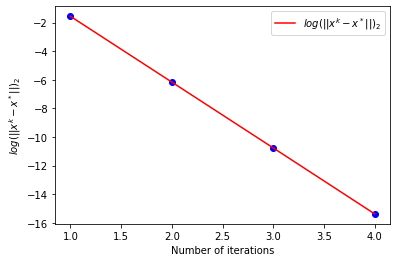

In [100]:
itr_last = [i+1 for i in np.arange(len(x_arr_newton))]
plt.plot(itr_last, x_arr_newton, color = "red")
plt.scatter(itr_last, x_arr_newton, color = "blue")
plt.xlabel('Number of iterations')
plt.ylabel('$log(||x^k - x^*||)_2$')
plt.legend(['$log(||x^k - x^*||)_2$'])
plt.show()

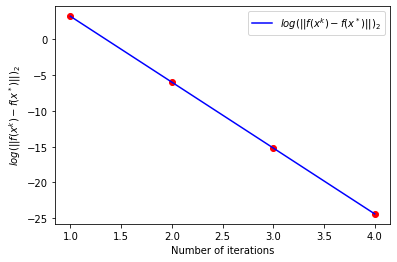

In [102]:
plt.plot(itr_last, func_arr_newton, color = "blue")
plt.scatter(itr_last, func_arr_newton, color = "red")
plt.xlabel('Number of iterations')
plt.ylabel('$log(||f(x^k) - f(x^*)||)_2$')
plt.legend(['$log(||f(x^k) - f(x^*)||)_2$'])
plt.show()

### **Observations:**

*  In this problem the hessian matrix comes out to be $A^TA$ which is a $10 \ Χ \ 10$ matrix and hence the inverse is easily computable in this case.
*   The loss function has converged Q-linearly here.

Condition of Q-linearity: \
$$\frac{||x^{(k+1)} - x^*||_2}{||x^k -x^*||_2} \le r , \ where \ r \in (0,1) \\ \implies log(||x^{(k+1)} - x^*||_2)  - log (||x^k -x^*||_2) \le log(r) \le 0 (because \ r \in (0,1)) \\ \implies log(||x^{(k+1)} - x^*||_2)  - log (||x^k -x^*||_2) \le 0 \\ \implies log(||x^{(k+1)} - x^*||_2) \le  log (||x^k -x^*||_2)$$

$where \ x_k \rightarrow x^*$

From the graph, we can see that all the conditions of Q-linearity are satisfied in this case as the graph of $log(||x^k - x^*||_2)$ is decresing linearly wrt k.


## **Answer 3:**

In [105]:
def find_minimizer_BFGS(start_x, n, tol, line_search_type, *args):
  assert type(start_x) is np.ndarray and len(start_x) == n 
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,n)
  I = np.identity(n)
  B_k = (1/8)*I

  #initialization for backtracking line search
  if line_search_type == BACKTRACKING_LINE_SEARCH:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  x_array = []
  while (np.linalg.norm(g_x) > tol):
    p_k = -np.matmul(B_k, g_x)
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(n,x, g_x,p_k, alpha_start, rho, gamma)
    else:
      raise ValueError('Line search type unknown. Please check!')

    x_0 = x
    x = np.add(x, np.multiply(step_length,p_k))
    s_k = x - x_0
    y_k = evalg(x,n)-evalg(x_0,n)

    u_k = (np.matmul(y_k.T,s_k))**(-1)
    first_term = np.subtract(I , u_k*np.matmul(s_k,y_k.T))
    second_term = np.subtract(I , u_k*np.matmul(y_k, s_k.T))
    B_k = np.matmul(np.matmul(first_term,B_k),second_term) + u_k*np.matmul(s_k,s_k.T)

    k += 1 #increment iteration
    g_x = evalg(x,n) #compute gradient at new point
    x_array.append(x)
    
  return x, k, x_array

In [107]:
my_start_x =np.zeros((10, 1))
my_tol= 1e-4
n = len(my_start_x)
alpha = 0.99
rho = 0.5
gamma = 0.5

time_start_bfgs = timer()
x1, k1, x_array = find_minimizer_BFGS(my_start_x, n, my_tol, BACKTRACKING_LINE_SEARCH,alpha, rho, gamma)
time_end_bfgs = timer()

x_arr_bfgs=[]
func_arr_bfgs=[]
for i in range(k1-1):
  x_arr_bfgs.append(math.log(np.linalg.norm(x_array[i] - x_bar)))
  func_arr_bfgs.append(math.log(np.linalg.norm(evalf(x_array[i],n) - evalf(x_bar,n))))

table2= []
col = ["Optimizer x*","Optimum value", "No. of iterations", "x_bar","function value at x_bar","Time"]
table2.append(col)
table2.append([x1, evalf(x1,n), k1, x_bar,evalf(x_bar,n), time_end_bfgs - time_start_bfgs])
print(tabulate(table2, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════════════╤═════════════════╤═════════════════════╤═════════════════╤═══════════════════════════╤══════════╕
│ Optimizer x*    │   Optimum value │   No. of iterations │ x_bar           │   function value at x_bar │     Time │
╞═════════════════╪═════════════════╪═════════════════════╪═════════════════╪═══════════════════════════╪══════════╡
│ [[-1.34549073]  │         499.395 │                  18 │ [[-1.34641041]  │                   503.647 │ 0.016595 │
│  [ 2.12383329]  │                 │                     │  [ 2.11500694]  │                           │          │
│  [-3.04798162]  │                 │                     │  [-3.04971714]  │                           │          │
│  [ 4.44920401]  │                 │                     │  [ 4.4821914 ]  │                           │          │
│  [-5.10390257]  │                 │                     │  [-5.12752546]  │                           │          │
│  [ 6.16488206]  │                 │                     │  [ 6

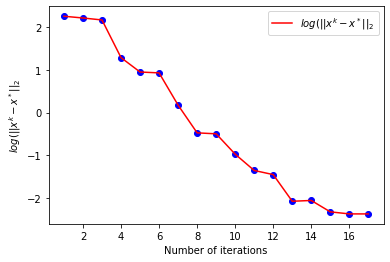

In [109]:
itr_lst1 = [i+1 for i in np.arange(len(x_arr_bfgs))]
plt.plot(itr_lst1, x_arr_bfgs,color = "red")
plt.scatter(itr_lst1, x_arr_bfgs,color = "blue")
plt.xlabel('Number of iterations')
plt.ylabel('$log(||x^k - x^*||_2$')
plt.legend(['$log(||x^k - x^*||_2$'])
plt.show()

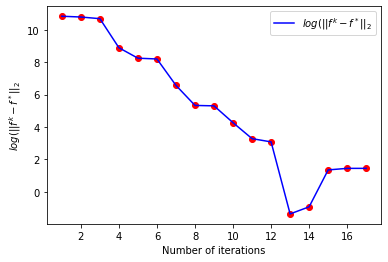

In [111]:
plt.plot(itr_lst1, func_arr_bfgs, color = "blue")
plt.scatter(itr_lst1, func_arr_bfgs, color = "red")
plt.xlabel('Number of iterations')
plt.ylabel('$log(||f^k - f^*||_2$')
plt.legend(['$log(||f^k - f^*||_2$'])
plt.show()

### **Observations:**

*   The loss function has converged Q-linearly here.

Condition of Q-linearity: \
$$\frac{||x^{(k+1)} - x^*||_2}{||x^k -x^*||_2} \le r , \ where \ r \in (0,1) \\ \implies log(||x^{(k+1)} - x^*||_2)  - log (||x^k -x^*||_2) \le log(r) \le 0 (because \ r \in (0,1)) \\ \implies log(||x^{(k+1)} - x^*||_2)  - log (||x^k -x^*||_2) \le 0 \\ \implies log(||x^{(k+1)} - x^*||_2) \le  log (||x^k -x^*||_2)$$

$where \ x_k \rightarrow x^*$

From the graph, we can see that the graph of $log(||x^k - x^*||_2)$ 
is not strictly decreasing, but monotonically decreasing which was not the case with the **Newton's method**, there the graph was strictly decreasing. But still we only want the graph to be decreasing with respect to $k$ and hence all the conditions of Q-linearity are satisfied in this case.

## **Answer 4:**

In [122]:
table_time = []
col = ["Method name", "Optimizer x*","Optimum value","Time taken", "Number of iterations"]
table_time.append(col)
table_time.append(["Newton's method" ,opt_x, evalf(opt_x,n), time_end_new-time_start_new,k])
table_time.append(["BFGS method" ,  x1, evalf(x1,n),time_end_bfgs - time_start_bfgs,k1])
print(tabulate(table_time , headers = "firstrow" , tablefmt ="fancy_grid" ))

╒═════════════════╤═════════════════╤═════════════════╤══════════════╤════════════════════════╕
│ Method name     │ Optimizer x*    │   Optimum value │   Time taken │   Number of iterations │
╞═════════════════╪═════════════════╪═════════════════╪══════════════╪════════════════════════╡
│ Newton's method │ [[-1.34549073]  │         499.395 │   0.00217816 │                      5 │
│                 │  [ 2.12383328]  │                 │              │                        │
│                 │  [-3.04798162]  │                 │              │                        │
│                 │  [ 4.44920401]  │                 │              │                        │
│                 │  [-5.10390258]  │                 │              │                        │
│                 │  [ 6.16488207]  │                 │              │                        │
│                 │  [-8.02065328]  │                 │              │                        │
│                 │  [ 8.42283343]  │   

### **Observations:**
We can see from the table that optimal x values and the functional value in both the methods are coming out to be almost same, with a very small difference. But number of iterations taken by Newton's method is 5 while that by BFGS method is 18. And time taken by BFGS method is approximately 8 times than that of Newton Method, which does not make much impact here but if we increase the size of matrix A or the size of x, it can lead to a huge difference.

Hence we can conclude from here that in case of OLS optimization, **Newton's method works better than BFGS method.**